
<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/>

# PyTorch implementation of Linear Regression #
By Richard Sowers
* <r-sowers@illinois.edu>
* <https://publish.illinois.edu/r-sowers/>

Copyright 2020 University of Illinois Board of Trustees. All Rights Reserved.

Pytorch documentation: <https://pytorch.org/docs/stable/index.html>

data source: https://archive.ics.uci.edu/ml/datasets/QSAR+fish+toxicity

### imports and graphics configurations ###

In [1]:
import torch
import os
import numpy
import pandas
import time
import random
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
#from pandas.plotting import autocorrelation_plot
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter

import imageio
import PIL

def saver(fname):
    plt.savefig(fname+".png",bbox_inches="tight")
    
def legend(pos="bottom",ncol=3,extra=False):
    if pos=="bottom":
        extra = 0.15 if extra else 0
        plt.legend(bbox_to_anchor=(0.5,-0.2-extra), loc='upper center',facecolor="lightgray",ncol=ncol)
    elif pos=="side":
        plt.legend(bbox_to_anchor=(1.1,0.5), loc='center left',facecolor="lightgray",ncol=1)
        
def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()

In [2]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5
}
plt.rcParams.update(params)

In [3]:
pngfiles=[f for f in os.listdir(".") if f.endswith(".png")]
print("existing png files: "+str(pngfiles))
#print([os.remove(f) for f in pngfiles])

existing png files: []


In [4]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pandas.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out=pandas.read_csv(loc,**kwargs)
    return out

### configuration variables###

In [5]:
fname=("qsar_fish_toxicity.csv","https://drive.google.com/file/d/1xd30VCQ2clQPzHDXpDi-VPU6pGTIUmQg/view?usp=sharing")

data_color="red"
markersize=2
thinlinesize=2
textboxsize=(5,0.5)

### code starts here###

In [6]:
columns=[
"CIC0",
"SM1_Dz(Z)",
"GATS1i",
"NdsCH",
"NdssC",
"MLOGP",
"LC50" #response
]
(feature,response)=("MLOGP","LC50")

In [7]:
data_raw=getfile(fname,sep=";",names=columns)

local file not found; accessing Google Drive


In [8]:
data=data_raw.copy()
X=data[feature].values
Y=data[response]

In [9]:
print(X.shape)

(908,)


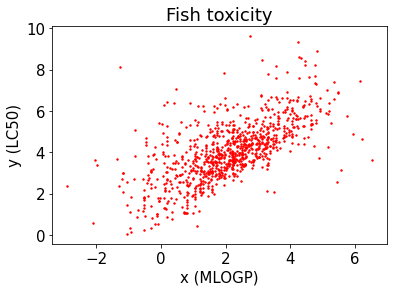

In [10]:
plt.figure()
plt.scatter(X,Y,color=data_color,s=markersize)
title=[]
title.append("Fish toxicity")
plt.title("\n".join(title))
plt.xlabel("x ({0:s})".format(feature))
plt.ylabel("y ({0:s})".format(response))
plt.show()
plt.close()

For reference, let's use scipy.stats

In [11]:
m_sp,b_sp,_,_,_=scipy.stats.linregress(X,Y)

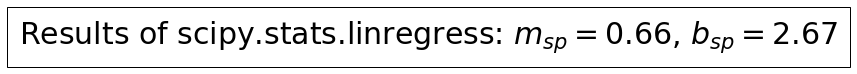

In [12]:
text=[]
text.append("Results of scipy.stats.linregress: $m_{{sp}}={0:.2f}$, $b_{{sp}}={1:.2f}$".format(m_sp,b_sp))
textbox(text)

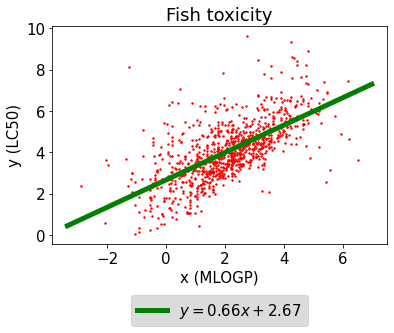

In [13]:
plt.figure()
plt.scatter(X,Y,color=data_color,s=markersize)
title=[]
title.append("Fish toxicity")
plt.title("\n".join(title))
plt.xlabel("x ({0:s})".format(feature))
plt.ylabel("y ({0:s})".format(response))
xrange=numpy.array(plt.xlim())
plt.plot(xrange,m_sp*xrange+b_sp,color="green",label=r"$y={0:.2f}x+{1:.2f}$".format(m_sp,b_sp))
legend("bottom")
plt.show()
plt.close()

## Implement with PyTorch ##

In [14]:
X_pt=numpy.array(X,dtype=numpy.float32).reshape(-1,1)
Y_pt=numpy.array(Y,dtype=numpy.float32).reshape(-1,1)

# Convert inputs and labels to Variable, paralellizing if cuda is available
if torch.cuda.is_available():
    print("cuda is available")
    inputs = torch.tensor(torch.from_numpy(X_pt.cuda()))
    labels = torch.tensor(torch.from_numpy(Y_pt.cuda()))
else:
    print("cuda is not available")
    inputs = torch.from_numpy(X_pt)
    labels = torch.from_numpy(Y_pt)

cuda is not available


In [15]:
learningRate=0.075

In [16]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize=1, outputSize=1): #default to one-dimensional feature and response
        super().__init__() #run init of torch.nn.Module
        self.linear = torch.nn.Linear(inputSize,outputSize)

    def forward(self, x):
        out=self.linear(x)
        return out

torch.manual_seed(0)
model=linearRegression()
if torch.cuda.is_available():
    model.cuda()

Loss = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [17]:
torch.manual_seed(0)
MAX_iter = 200  
for itr in range(MAX_iter):

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    lossvalue = Loss(outputs, labels)

    # get gradients w.r.t to parameters
    lossvalue.backward()
    #print(model.linear.weight.grad.item(),model.linear.bias.grad.item())

    # update parameters
    optimizer.step()
    if itr%10==0:
      print("iteration {}: loss={:.5f}, m={:.3f}, b={:.2f}, d/dm={:.2f}, d/db={:.2f}".format(itr, lossvalue.item(),
        model.linear.weight.item(),model.linear.bias.item(),model.linear.weight.grad.item(),model.linear.bias.grad.item()))

iteration 0: loss=14.69554, m=1.320, b=1.07, d/dm=-17.70, d/db=-7.09
iteration 10: loss=1.60470, m=1.021, b=1.61, d/dm=0.21, d/db=-0.63
iteration 20: loss=1.37964, m=0.894, b=1.98, d/dm=0.14, d/db=-0.41
iteration 30: loss=1.28550, m=0.812, b=2.23, d/dm=0.09, d/db=-0.26
iteration 40: loss=1.24613, m=0.759, b=2.38, d/dm=0.06, d/db=-0.17
iteration 50: loss=1.22966, m=0.725, b=2.48, d/dm=0.04, d/db=-0.11
iteration 60: loss=1.22278, m=0.703, b=2.55, d/dm=0.02, d/db=-0.07
iteration 70: loss=1.21989, m=0.688, b=2.59, d/dm=0.02, d/db=-0.05
iteration 80: loss=1.21869, m=0.679, b=2.62, d/dm=0.01, d/db=-0.03
iteration 90: loss=1.21819, m=0.673, b=2.64, d/dm=0.01, d/db=-0.02
iteration 100: loss=1.21798, m=0.669, b=2.65, d/dm=0.00, d/db=-0.01
iteration 110: loss=1.21789, m=0.666, b=2.65, d/dm=0.00, d/db=-0.01
iteration 120: loss=1.21785, m=0.665, b=2.66, d/dm=0.00, d/db=-0.01
iteration 130: loss=1.21783, m=0.664, b=2.66, d/dm=0.00, d/db=-0.00
iteration 140: loss=1.21783, m=0.663, b=2.66, d/dm=0.00,

In [18]:
(m_pt,b_pt)=(model.linear.weight.item(),model.linear.bias.item())

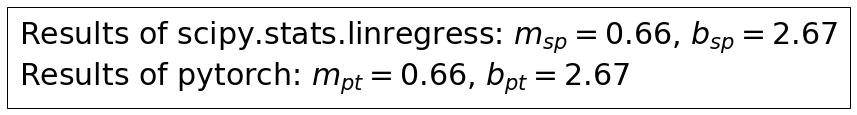

In [19]:
text=[]
text.append("Results of scipy.stats.linregress: $m_{{sp}}={0:.2f}$, $b_{{sp}}={1:.2f}$".format(m_sp,b_sp))
text.append("Results of pytorch: $m_{{pt}}={0:.2f}$, $b_{{pt}}={1:.2f}$".format(m_pt,b_pt))
textbox(text)